In [1]:
!nvidia-smi

Mon Jul 11 12:13:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import necessary Libraries
import keras
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Activation,GlobalAveragePooling2D
import random
import pickle
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model

In [4]:
training_file = "/content/drive/MyDrive/train.p"
validation_file= "/content/drive/MyDrive/valid.p"
testing_file = "/content/drive/MyDrive/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [ ]:
# from PIL import Image
# cur_path =r'/content/drive/MyDrive/'
# print(cur_path)
# path = os.path.join(cur_path,'Train',str(0))


In [ ]:
# data = []
# labels = []
# classes = 43
 

# #Retrieving the images and their labels 
# for i in range(classes):
#     path = os.path.join(cur_path,'Train',str(i))
#     images = os.listdir(path)

#     for a in images:
#         try:
#             image = Image.open(path + '/'+ a)
#             image = image.resize((30,30))
#             image = np.array(image)
    
#             #data.append(image)
#             #labels.append(i)
#             data.append([image,i]) #appending all value together 
#         except:
#             print("Error loading image")

In [5]:
#Split Train, Validation and Test samples and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Check to ensure features equals labels for each data set
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Print shapes of training, validation and test data
print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid[0].shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test.shape)

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train)) 
print("Number of classes =", n_classes)

X_train shape: (32, 32, 3)
y_train shape: (34799,)
X_valid shape: (32, 32, 3)
y_valid shape: (4410,)
X_test shape: (32, 32, 3)
y_test shape: (12630,)
Number of classes = 43


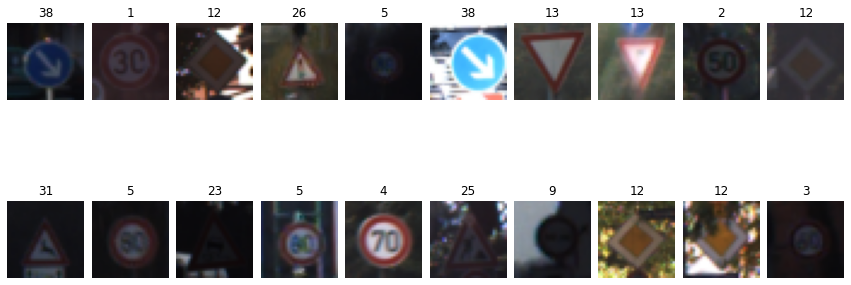

In [6]:
fig, axs = plt.subplots(2,10, figsize=(15, 6)) 
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

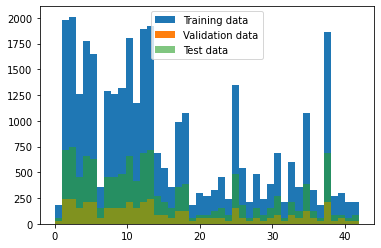

In [7]:
# Histogram of Image Class Distribution

a = y_train
b = y_valid
c = y_test
bins = n_classes
plt.hist(a, bins, alpha = 1.0, label='Training data')
plt.hist(b, bins, alpha = 1.0, label='Validation data')
plt.hist(c, bins, alpha = 0.6, label='Test data')
plt.legend(loc='upper center')

plt.show()

In [8]:
## Data augmentation-Rotation
def rotate_image(imager,degree):
    X_rotated=[]
    for im in (imager):
      rotated_image = scipy.ndimage.rotate(im, degree)
      X_rotated.append(rotated_image)
    return X_rotated

def  crop_image(imager):
    for i in range(len(imager)):
      imager[i] = imager[i][2:34,2:34]   # box=(y:y+crop, x:x+crop)
    return imager

X_train_rotated_positive=rotate_image(X_train,10)
X_train_rotated_negative=rotate_image(X_train,350)
X_train_rotated_positive=crop_image(X_train_rotated_positive)
X_train_rotated_negative=crop_image(X_train_rotated_negative)
    
# appending rotated images to training set
# Convert the data into list type to use the method "append"
X_train = list(X_train)

# combine the Lists
for i in range(len(X_train_rotated_positive)):
    X_train.append(X_train_rotated_positive[i])
    X_train.append(X_train_rotated_negative[i])
    
#Convert the data back to a np.array
X_train = np.array(X_train)

# New number of training examples (after data augmentation)
new_n_train = len(X_train)
print("New number of training samples after data augmentation =", new_n_train)
# do the same for the labels y_train
# Convert the data into list type to use the method "append"
y_train = list(y_train)

# lengthen the list
for i in range(len(y_train)):
    y_train.append(y_train[i])
    y_train.append(y_train[i]) 
#Convert the data back to a np.array
y_train = np.array(y_train)
# New length of ground truth labels
new_n_train_y = len(y_train)
print("New length of ground truth labels =", new_n_train_y)

New number of training samples after data augmentation = 104397
New length of ground truth labels = 104397


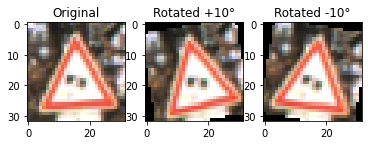

In [9]:
# Display an example for rotation

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(X_train[2018])
ax1.set_title('Original')    
ax1.axis('ON')  # clear x- and y-axes
ax2.imshow(X_train_rotated_positive[2018])
ax2.set_title('Rotated +10°')    
ax2.axis('ON')  # clear x- and y-axes
ax3.imshow(X_train_rotated_negative[2018])
ax3.set_title('Rotated -10°')   
ax3.axis('ON')  # clear x- and y-axes
plt.show()
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
def normalize(image):
    normal=[]
    for im in image:
      norm=cv2.equalizeHist(norm2)
      normal.append(np.reshape(norm, (im.shape[0],im.shape[1],im.shape[2])))          
    return normal

In [ ]:
#Normalize images
import gc
gc.collect()
X_train_normalized = []
X_valid_normalized = []
X_test_normalized = []
X_train_normalized=normalize(X_train)
X_valid_normalized=normalize(X_valid)
X_test_normalized=normalize(X_test)

X_train_normalized=np.array(X_train_normalized)
X_valid_normalized=np.array(X_valid_normalized)
X_test_normalized=np.array(X_test_normalized)

print(X_train_normalized.shape)
print(X_valid_normalized.shape)
print(X_test_normalized.shape)



In [ ]:
#Building the CNN model
modelCNN=None
modelCNN = Sequential()
modelCNN.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Conv2D(64, (3, 3), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Conv2D(128, (3, 3), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelCNN.add(Dense(512))
modelCNN.add(Activation('relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(43, activation='softmax'))


modelCNN.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                  metrics=['accuracy'])

plot_model(modelCNN, to_file='/content/drive/MyDrive/modelCNN.png', show_shapes=True, show_layer_names=True)
modelCNN.summary()

historyCNN=modelCNN.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_valid, y_valid))
modelCNN.save('/content/drive/MyDrive/modelCNN.h5')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_40 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_41 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

In [ ]:
from sklearn.metrics import accuracy_score,recall_score
results = modelCNN.evaluate(X_train, y_train, batch_size=32)
results = modelCNN.evaluate(X_valid, y_valid, batch_size=32)
results = modelCNN.evaluate(X_test, y_test, batch_size=32)

pred1 = np.argmax(modelCNN.predict(X_test), axis=-1)
print(accuracy_score(y_test, pred1))
print(recall_score(y_test, pred1, average='micro'))

395/395 [==============================] - 1s 3ms/step - loss: 1.2261 - accuracy: 0.9639
0.963895486935867
0.963895486935867


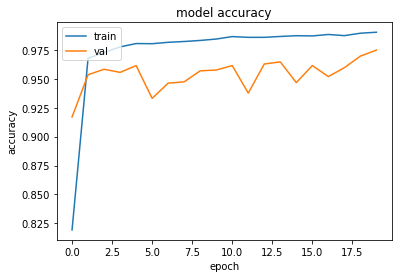

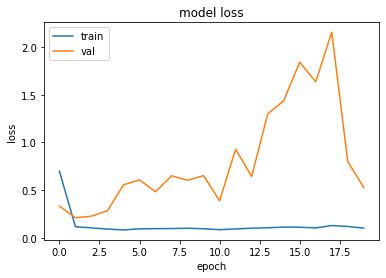

In [ ]:
plt.plot(historyCNN.history['accuracy'])
plt.plot(historyCNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyCNN.history['loss'])
plt.plot(historyCNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Model Mobile Net

base_modelMN = tf.keras.applications.MobileNet(classes=43,input_shape = (32, 32, 3), include_top = False, weights = 'imagenet')

modelMN = Sequential()
modelMN.add(base_modelMN)
modelMN.add(Flatten())
modelMN.add(Dense(512, activation='relu'))
modelMN.add(Dropout(0.6))
modelMN.add(Dense(43, activation='sigmoid'))

base_learning_rate = 0.001
modelMN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

plot_model(modelMN, to_file='/content/drive/MyDrive/modelMN.png', show_shapes=True, show_layer_names=True)
modelMN.summary()

historyMN = modelMN.fit(X_train,y_train,epochs = 20,batch_size=64 , validation_data = (X_valid, y_valid))
modelMN.save('/content/drive/MyDrive/modelMN.h5')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 43)                22059     
                                                                 
Total params: 3,775,723
Trainable params: 3,753,835
Non-trainable params: 21,888
______________________________________

In [ ]:
from sklearn.metrics import accuracy_score,recall_score
results = modelMN.evaluate(X_train, y_train, batch_size=64)
results = modelMN.evaluate(X_valid, y_valid, batch_size=64)
results = modelMN.evaluate(X_test, y_test, batch_size=64)

pred1 = np.argmax(modelMN.predict(X_test), axis=-1)
print(accuracy_score(y_test, pred1))
print(recall_score(y_test, pred1, average='micro'))

198/198 [==============================] - 2s 8ms/step - loss: 0.2570 - accuracy: 0.9444
0.9444180522565321
0.9444180522565321


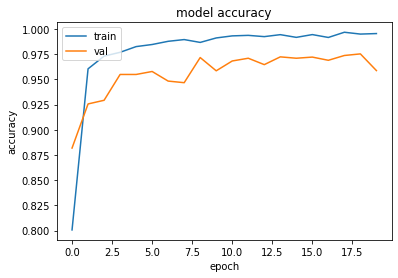

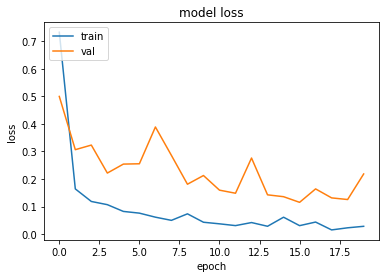

In [ ]:
plt.plot(historyMN.history['accuracy'])
plt.plot(historyMN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyMN.history['loss'])
plt.plot(historyMN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#model Densnet121

base_modelDN = tf.keras.applications.DenseNet121(classes=43,input_shape = (32, 32, 3), include_top = False, weights = 'imagenet')
modelDN = Sequential()
modelDN.add(base_modelDN)
modelDN.add(Flatten())
modelDN.add(Dense(512, activation='relu'))
modelDN.add(Dropout(0.5))
modelDN.add(Dense(43, activation='sigmoid'))

base_learning_rate = 0.001
modelDN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

plot_model(modelDN, to_file='/content/drive/MyDrive/modelDN.png', show_shapes=True, show_layer_names=True)
modelDN.summary()

historyDN = modelDN.fit(X_train,y_train,epochs = 10,batch_size=64 , validation_data = (X_valid, y_valid))
modelDN.save('/content/drive/MyDrive/modelDN.h5')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten_11 (Flatten)        (None, 1024)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 43)                22059     
                                                                 
Total params: 7,584,363
Trainable params: 7,500,715
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10
1632/1632 [================

In [ ]:
results = modelDN.evaluate(X_train, y_train, batch_size=64)
results = modelDN.evaluate(X_valid, y_valid, batch_size=64)
results = modelDN.evaluate(X_test, y_test, batch_size=64)

pred1 = np.argmax(modelDN.predict(X_test), axis=-1)
print(accuracy_score(y_test, pred1))
print(recall_score(y_test, pred1, average='micro'))

198/198 [==============================] - 4s 21ms/step - loss: 0.2466 - accuracy: 0.9503
0.95027711797308
0.95027711797308


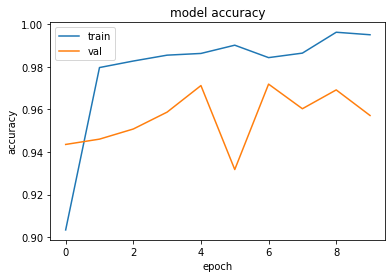

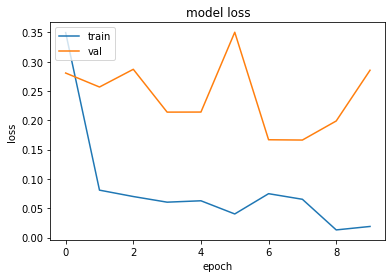

In [ ]:
plt.plot(historyDN.history['accuracy'])
plt.plot(historyDN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyDN.history['loss'])
plt.plot(historyDN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization

#Resnet50
from tensorflow.keras.applications import ResNet50V2

base_modelRN = ResNet50V2(input_shape = (32, 32, 3), include_top = False, weights = 'imagenet')
modelRN = Sequential()
modelRN.add(base_modelRN)
modelRN.add(GlobalAveragePooling2D())
modelRN.add(Flatten())
modelRN.add(Dense(43, activation='softmax'))
                               
base_learning_rate = 0.001
modelRN.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

plot_model(modelRN, to_file='/content/drive/MyDrive/modelRN.png', show_shapes=True, show_layer_names=True)
modelRN.summary()

historyRN = modelRN.fit(X_train,y_train,epochs = 10 , validation_data = (X_valid, y_valid),steps_per_epoch = 100)
modelRN.save('/content/drive/MyDrive/modelRN.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 43)                88107     
                                                                 
Total params: 23,652,907
Trainable params: 23,607,467
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 48s 378ms/step - loss: 1.7083 - accuracy: 0.5458 

In [ ]:
from sklearn.metrics import accuracy_score,recall_score
results = modelRN.evaluate(X_train, y_train, batch_size=64)
results = modelRN.evaluate(X_valid, y_valid, batch_size=64)
results = modelRN.evaluate(X_test, y_test, batch_size=64)

pred1 = np.argmax(modelRN.predict(X_test), axis=-1)
print(accuracy_score(y_test, pred1))
print(recall_score(y_test, pred1, average='micro'))

198/198 [==============================] - 3s 16ms/step - loss: 0.6191 - accuracy: 0.9178
0.9178147268408551
0.9178147268408551


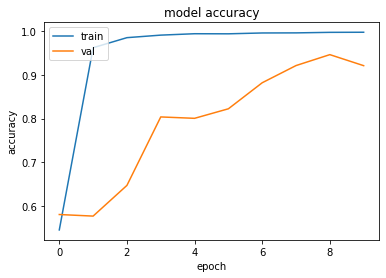

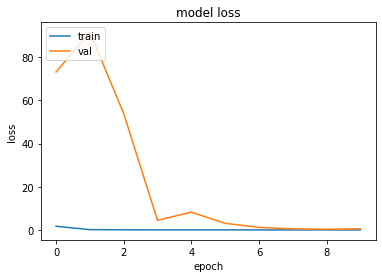

In [ ]:
plt.plot(historyRN.history['accuracy'])
plt.plot(historyRN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyRN.history['loss'])
plt.plot(historyRN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Efficient Model
base_modelEN=tf.keras.applications.efficientnet.EfficientNetB0(input_shape = (32, 32, 3), classes=43,include_top = False, weights = 'imagenet', pooling='max')
  
modelEN = Sequential()
modelEN.add(base_modelEN)
modelEN.add(Dense(43, activation='sigmoid'))

modelEN.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ['accuracy'])

plot_model(modelEN, to_file='/content/drive/MyDrive/modelEN.png', show_shapes=True, show_layer_names=True)
modelEN.summary()

historyEN = modelEN.fit(X_train,y_train, validation_data = (X_valid, y_valid), steps_per_epoch = 100, epochs = 20)
modelEN.save('/content/drive/MyDrive/modelEN.h5')


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_13 (Dense)            (None, 43)                55083     
                                                                 
Total params: 4,104,654
Trainable params: 4,062,631
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/20
100/100 [==============================] - 32s 228ms/step - loss: 0.6732 - accuracy: 0.8116 - val_loss: 1.0744 - val_accuracy: 0.7181
Epoch 2/20
100/100 [==============================] - 22s 216ms/step - loss: 0.0320 - accuracy: 0.9900 - val_loss: 0.6632 - val_accuracy: 0.8302
Epoch 3/20
100/100 [==============================] - 21s 214ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.6456 - val_accuracy: 0.8574

In [ ]:
results = modelEN.evaluate(X_train, y_train, batch_size=64)
results = modelEN.evaluate(X_valid, y_valid, batch_size=64)
results = modelEN.evaluate(X_test, y_test, batch_size=64)

pred1 = np.argmax(modelEN.predict(X_test), axis=-1)
print(accuracy_score(y_test, pred1))
print(recall_score(y_test, pred1, average='micro'))

198/198 [==============================] - 3s 13ms/step - loss: 0.4565 - accuracy: 0.9196
0.919477434679335
0.919477434679335


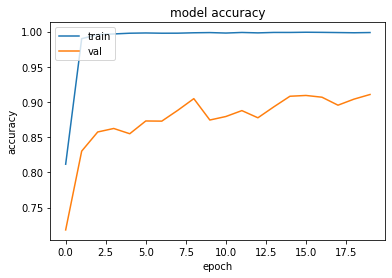

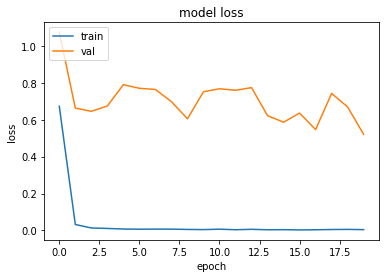

In [ ]:
plt.plot(historyEN.history['accuracy'])
plt.plot(historyEN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyEN.history['loss'])
plt.plot(historyEN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack

# load models from file


def load_all_models():
  all_models = list()
  model = load_model('/content/drive/MyDrive/modelCNN.h5')
  all_models.append(model)
  model = load_model('/content/drive/MyDrive/modelMN.h5')
  all_models.append(model)
  model = load_model('/content/drive/MyDrive/modelDN.h5')
  all_models.append(model)
  model = load_model('/content/drive/MyDrive/modelRN.h5')
  all_models.append(model)
  model = load_model('/content/drive/MyDrive/modelEN.h5')
  all_models.append(model)
  return all_models

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

  # fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

members = load_all_models()
# evaluate standalone models on test dataset
for model in members:
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('Model Accuracy: %.3f' % acc)


# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, y_test)
# create stacked model input dataset as outputs from the ensemble
# evaluate model on test set
yhat = stacked_prediction(members, model, X_test)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Model Accuracy: 0.964
Model Accuracy: 0.944
Model Accuracy: 0.950
Model Accuracy: 0.918
Model Accuracy: 0.920


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Stacked Test Accuracy: 1.000


In [13]:
  def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num
  
  
  img = image.load_img('/content/drive/MyDrive/00008.png', target_size = (32,32)) #load the image
  x = image.img_to_array(img)
  #x = np.expand_dims(x, axis=0)
  #images = np.vstack([x])
  image1=np.reshape(x,(1,32,32,3)) 
  valu=[]
  valu.append(np.argmax(members[0].predict(image1),axis=-1)) #predict the label for the image
  valu.append(np.argmax(members[1].predict(image1),axis=-1))
  valu.append(np.argmax(members[2].predict(image1),axis=-1))
  valu.append(np.argmax(members[3].predict(image1),axis=-1))
  valu.append(np.argmax(members[4].predict(image1),axis=-1))
  print(valu[0],valu[1],valu[2],valu[3],valu[4])
  classes=most_frequent(valu)
  if classes[0]==0:
    print('Speed limit (20km/h)') #print the content

  elif classes[0]==1:
      print('Speed limit (30km/h)') #print the content

  elif classes[0]==2:
      print('Speed limit (50km/h)') #print the content

  elif classes[0]==3:
      print(' Speed limit (60km/h)') #print the content

  elif classes[0]==4:
      print('Speed limit (70km/h)') #print the content

  elif classes[0]==5:
      print('Speed limit (80km/h)') #print the content

  elif classes[0]==6:
      print('End of speed limit (80km/h)') #print the content

  elif classes[0]==7:
      print('Speed limit (100km/h)') #print the content

  elif classes[0]==8:
      print('Speed limit (120km/h)') #print the content

  elif classes[0]==9:
      print('No passing') #print the content
        
  elif classes[0]==10:
      print('No passing veh over 3.5 tons') #print the content 
        
  elif classes[0]==11:
      print(', Right-of-way at intersection') #print the content
        
  elif classes[0]==12:
      print('Priority road') #print the content
        
  elif classes[0]==13:
      print('Yield') #print the content       
        
  elif classes[0]==14:
      print('Stop') #print the content       
        
  elif classes[0]==15:
      print('No vehicles') #print the content
                
  elif classes[0]==16:
      print('Veh > 3.5 tons prohibited') #print the content       
        
  elif classes[0]==17:
      print('No entry') #print the content        
                       
  elif classes[0]==18:
      print('General caution') #print the content       
                
  elif classes[0]==19:
      print('Dangerous curve left') #print the content        
        
  elif classes[0]==20:
      print('Dangerous curve right') #print the content        
        
  elif classes[0]==21:
      print('Double curve') #print the content       
        
  elif classes[0]==22:
      print('Bumpy road') #print the content        
                
  elif classes[0]==23:
      print('Slippery road') #print the content        
        
  elif classes[0]==24:
      print('Road narrows on the right') #print the content               
        
  elif classes[0]==25:
      print('Road work') #print the content        
        
  elif classes[0]==26:
      print('Traffic signals') #print the content
        
  elif classes[0]==27:
      print('Pedestrians') #print the content       
                
  elif classes[0]==28:
      print('Children crossing') #print the content
        
  elif classes[0]==29:
      print( 'Bicycles crossing') #print the content
               
  elif classes[0]==30:
      print('Beware of ice/snow') #print the content        
        
  elif classes[0]==31:
      print('Wild animals crossing') #print the content        
               
  elif classes[0]==32:
      print('End speed + passing limits') #print the content        
        
  elif classes[0]==33:
      print('Turn right ahead') #print the content
        
  elif classes[0]==34:
      print('Turn left ahead') #print the content        
        
  elif classes[0]==35:
      print('Ahead only') #print the content        
        
  elif classes[0]==36:
      print('Go straight or right') #print the content
        
  elif classes[0]==37:
      print('Go straight or left') #print the content        
        
  elif classes[0]==38:
      print('Keep right') #print the content
        
  elif classes[0]==39:
      print('Keep left') #print the content       
        
  elif classes[0]==40:
      print('Roundabout mandatory') #print the content

  elif classes[0]==41:
      print('End of no passing') #print the content        
        
  else:
      print('End no passing veh > 3.5 tons') #print the content

[25] [25] [25] [25] [25]
Road work
